In [1]:
# Sentiment Detector
#--- Install necessary packages ---
!pip install transformers datasets torch scikit-learn seaborn

In [2]:
# --- Import required libraries ---
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertConfig
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import Dataset
import random

c:\Users\Sourabh\anaconda3\envs\news_sentiment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# --- Seed control for reproducibility ---
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Check available device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if str(device) == "cuda":
    print(f"Detected GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
Detected GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [4]:
# --- Load the VERIFIED dataset and drop NaN values ---
try:
    train_df = pd.read_csv("train_model_1_neg_vs_notneg.csv")
    test_df = pd.read_csv("test_model_1_neg_vs_notneg.csv")
except FileNotFoundError:
    print("Error: Could not find the _model_1 CSV files. Make sure they are in the same directory.")

# Handle potential NaN values in text (from empty original descriptions)
train_df.dropna(subset=['text'], inplace=True)
test_df.dropna(subset=['text'], inplace=True)

# --- Prepare texts and labels ---
train_texts = train_df['text'].astype(str).tolist()
train_labels = train_df['label'].tolist()
test_texts = test_df['text'].astype(str).tolist()
test_labels = test_df['label'].tolist()

print(f"Loaded {len(train_texts)} training samples for Model 1.")
print(f"Loaded {len(test_texts)} test samples for Model 1.")

Loaded 3076 training samples for Model 1.
Loaded 347 test samples for Model 1.


In [5]:
# --- Tokenizer ---
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# --- Tokenize ---
train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=512)
test_encodings = tokenizer(test_texts, padding="max_length", truncation=True, max_length=512)

In [6]:
# --- Dataset class ---
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {k: torch.tensor(v, dtype=torch.long) for k, v in encodings.items()}
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx],
        }

In [7]:
# --- Create datasets ---
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [8]:
# --- Model config with num_labels=2 ---
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=2) # 0=Negative, 1=Not-Negative
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# --- Metrics (for Binary Classification) ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="binary"),
        "recall": recall_score(labels, preds, average="binary"),
        "f1": f1_score(labels, preds, average="binary"),
    }

# --- TrainingArguments ---
training_args = TrainingArguments(
    output_dir="./results_model_1",
    eval_strategy="steps",
    eval_steps=300,
    save_strategy="steps",
    save_steps=300,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,  # We can use fewer epochs, this task is easier
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir="./logs_model_1",
    logging_steps=100,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1" # Focus on the F1 score for the best model
)

In [10]:
# --- Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [11]:
# --- Train Model 1 ---
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
300,0.174100,0.203358,0.927954,0.992593,0.920962,0.955437
600,0.058000,0.168179,0.959654,0.996416,0.955326,0.975439
900,0.021800,0.191242,0.962536,0.992908,0.962199,0.977312
1200,0.000900,0.194806,0.962536,0.992908,0.962199,0.977312
1500,0.017700,0.185001,0.965418,0.989474,0.969072,0.979167
1800,0.000400,0.179745,0.968300,0.989510,0.972509,0.980936


TrainOutput(global_step=1925, training_loss=0.07683010979664404, metrics={'train_runtime': 603.0561, 'train_samples_per_second': 25.503, 'train_steps_per_second': 3.192, 'total_flos': 4046648031436800.0, 'train_loss': 0.07683010979664404, 'epoch': 5.0})

In [12]:
# --- Evaluate Model 1 ---
print("--- Evaluation Results for Model 1 ---")
metrics = trainer.evaluate()
print(metrics)
print("--------------------------------------")

--- Evaluation Results for Model 1 ---


{'eval_loss': 0.17974476516246796, 'eval_accuracy': 0.968299711815562, 'eval_precision': 0.9895104895104895, 'eval_recall': 0.9725085910652921, 'eval_f1': 0.9809358752166378, 'eval_runtime': 3.852, 'eval_samples_per_second': 90.083, 'eval_steps_per_second': 11.423, 'epoch': 5.0}
--------------------------------------


In [13]:
# --- Save Model 1 and tokenizer ---
model.save_pretrained("./bert_model_1_neg_vs_notneg")
tokenizer.save_pretrained("./bert_model_1_neg_vs_notneg")
print("Model 1 (Neg vs. Not-Neg) saved to ./bert_model_1_neg_vs_notneg")

Model 1 (Neg vs. Not-Neg) saved to ./bert_model_1_neg_vs_notneg



--- Final Classification Report for Model 1 ---
                  precision    recall  f1-score   support

    Negative (0)       0.87      0.95      0.91        56
Not-Negative (1)       0.99      0.97      0.98       291

        accuracy                           0.97       347
       macro avg       0.93      0.96      0.94       347
    weighted avg       0.97      0.97      0.97       347

---------------------------------


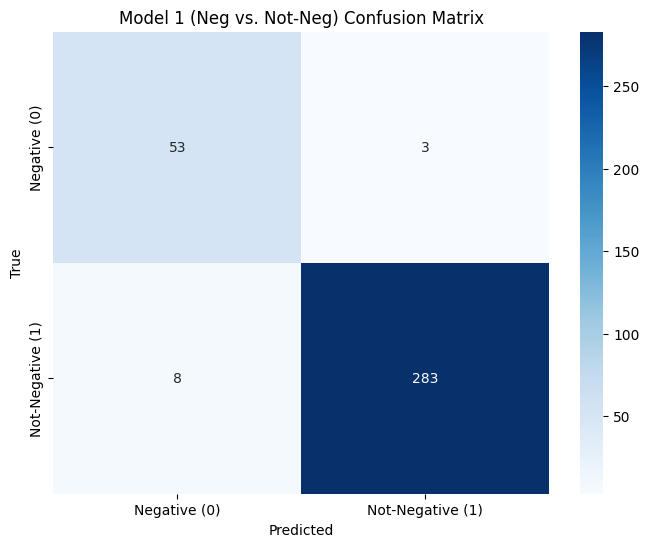

In [14]:
# --- Confusion Matrix for Model 1 ---
print("\n--- Final Classification Report for Model 1 ---")
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
target_names = ["Negative (0)", "Not-Negative (1)"]
print(classification_report(test_labels, y_pred, target_names=target_names))
print("---------------------------------")

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model 1 (Neg vs. Not-Neg) Confusion Matrix")
plt.show()